#     Credit Risk
##     NOVA IMS
####     Group G: Carlos Cardoso - 20211220 | Carlota Reis - 20211208 | Guilherme Miranda - 20210420 | Mariana Garcia - 20210838 

## IBM - International Business Machines Corporation

### This notebook uses the *Dataset.xlsx* dataset


### Initializations and data loading

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import scipy.optimize as opt
from math import exp, log, sqrt
from scipy.stats import norm
from datetime import datetime

In [2]:
# Loading the dataset
xls = pd.ExcelFile(r'C:\Users\lotar\OneDrive - NOVAIMS\3rd trimester\Credit Risk\Dataset.xlsx')
df = pd.read_excel(xls, 'Dataset')
df=pd.DataFrame(df)
df['Risk-free'] =df['Risk-free']/100


In [3]:
# Filter the DataFrame with only month-end dates
lastbday = (df['Date']+pd.offsets.BMonthEnd(1))
lastbday = lastbday.drop_duplicates( keep='first', inplace=False).reset_index(inplace=False)

df_month_end = df[df['Date'].isin(lastbday['Date'])].reset_index(drop=True)

#### 1. A) IBM firm fundamentals, summary statistics and graphical representation

In [4]:
#Summary Statistics
statistics=df.describe().T
statistics['median'] = df.median()
statistics

C:\Users\lotar\AppData\Local\Temp\ipykernel_22076\324966560.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  statistics['median'] = df.median()


,count,mean,std,min,25%,50%,75%,max,median
Last Price ($),1084.0,129.055631,11.415328,90.520900,119.529250,129.778150,136.953800,161.537300,129.778150
Shares Outstanding (millions),1084.0,899.121655,13.034850,885.637500,891.057100,892.653400,898.068600,922.179200,892.653400
MV Equity,1084.0,116101.928132,11167.331531,80302.040859,106986.459312,115898.644506,123053.228992,148966.338084,115898.644506
BV Equity,1084.0,19333.844096,1898.070548,16930.000000,17725.000000,18996.000000,20984.000000,22357.000000,18996.000000
Book-to-Market,1084.0,6.084115,0.976974,3.826822,5.230823,5.982453,7.009037,8.404307,5.982453
LT Debt,1084.0,45415.126384,11783.282368,29344.000000,33366.000000,50118.000000,56484.000000,59133.000000,50118.000000
ST Debt,1084.0,9000.358856,1835.579821,6535.000000,6987.000000,8860.000000,10207.000000,12969.000000,8860.000000
Total Debt,1084.0,54415.485240,12500.845392,39551.000000,40353.000000,58978.000000,65433.000000,70385.000000,58978.000000
Risk-free,1084.0,0.018573,0.007945,0.005069,0.012933,0.017365,0.026788,0.032373,0.017365


C:\Users\lotar\AppData\Local\Temp\ipykernel_22076\369199851.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


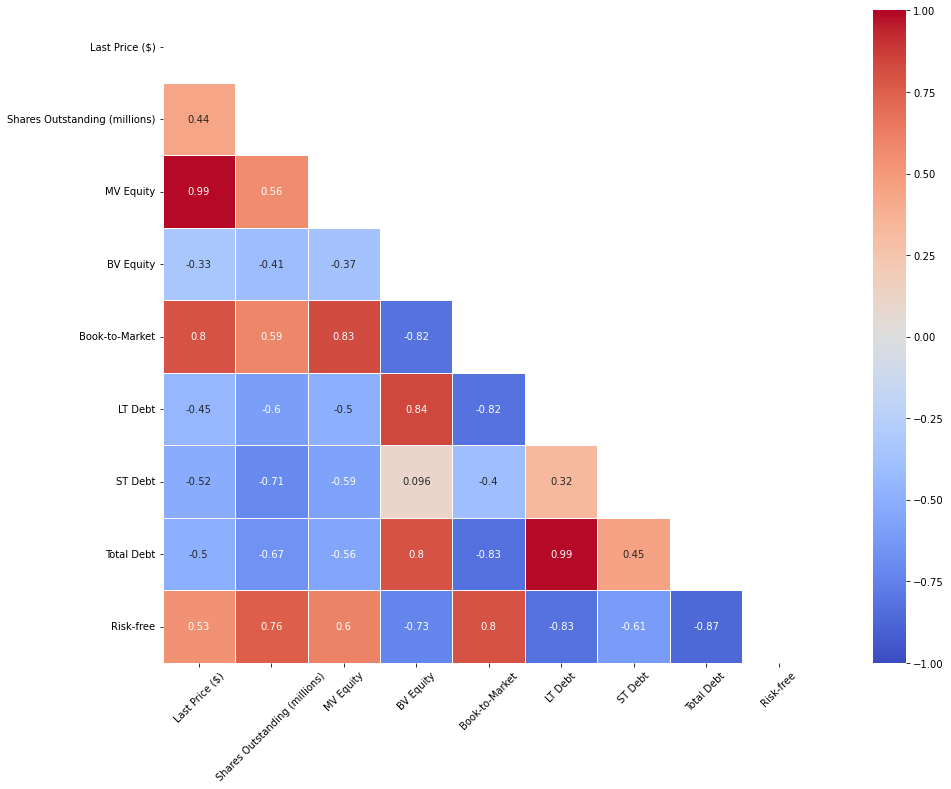

In [5]:
#Pearson Correlation Visualization

corr = df.corr()
f, ax = plt.subplots(figsize=(21, 12))
mask = np.zeros_like(corr, dtype=np.bool)

mask[np.triu_indices_from(mask)]= True


heatmap = sns.heatmap(corr,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 10})

#add the column names as labels
ax.set_yticklabels(corr.columns, rotation = 0)
ax.set_xticklabels(corr.columns, rotation = 45)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

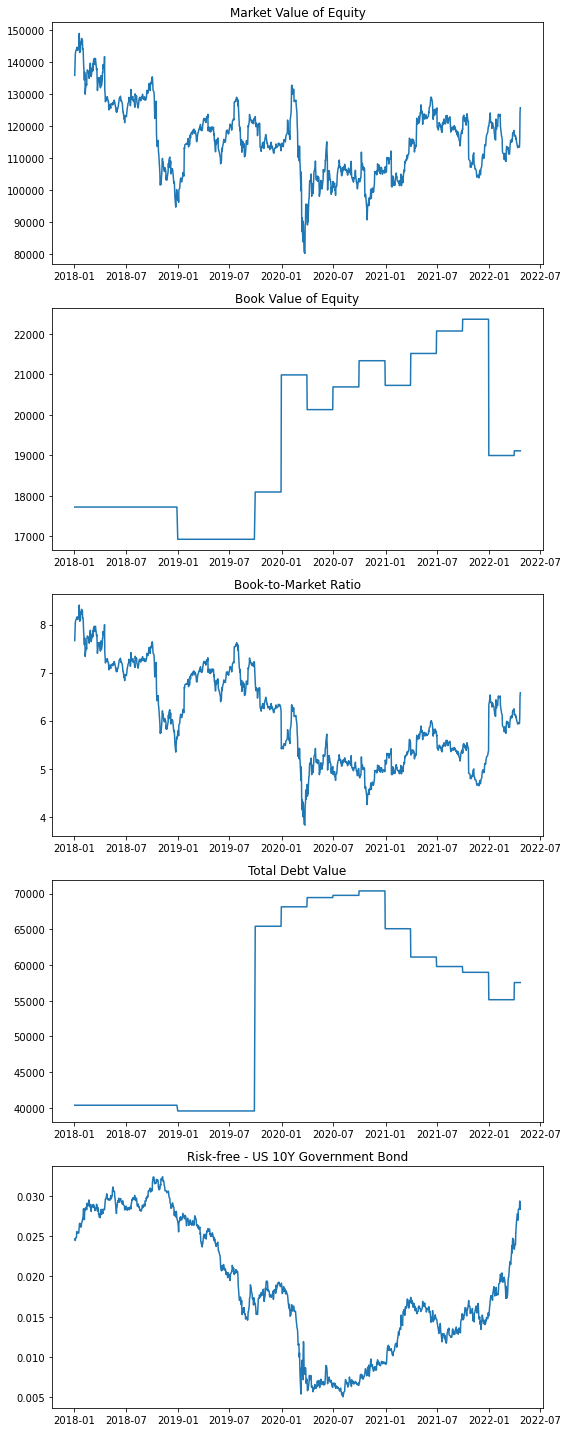

In [21]:
#Graphical Representations
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1, figsize=(8,20))
ax1.plot(df['Date'],df['MV Equity'])
ax2.plot(df['Date'],df['BV Equity'])
ax3.plot(df['Date'],df['Book-to-Market'])
ax4.plot(df['Date'],df['Total Debt'])
ax5.plot(df['Date'],df['Risk-free'])

ax1.set_title('Market Value of Equity')
ax2.set_title('Book Value of Equity')
ax3.set_title('Book-to-Market Ratio')
ax4.set_title('Total Debt Value')
ax5.set_title('Risk-free - US 10Y Government Bond')

plt.tight_layout()

1.b Non-linear system of equations approach. Distance to default and probability of default with E(return on assets) = risk-free

In [22]:
#Equation 5.1 (Equity as call option equation)

def Equity(spot,strike,tau,sigmaV,r):
    #Equation 5.1.
    
    d1 = (log(spot/strike)+(r+sigmaV**2/2.0)*tau)/(sigmaV*sqrt(tau))
    d2 = d1-sigmaV*sqrt(tau)
    
    y = spot*norm.cdf(d1) - strike*exp(-r*tau)*norm.cdf(d2) 
    
    return y


# y = market value of Equity
#strike price = debt
#spot price= Market Value of Assets
#tau = T-t = 1 year
#r = risk-free
#sigmaV = volatility assets = firm volatility

In [23]:
#Equation 5.2 (Equity volatility equation)

def EquityVol(spot,strike,tau,sigmaV,r,equity):
    #Equation 5.2.
    
    d1 = (log(spot/strike)+(r+sigmaV**2/2.0)*tau)/(sigmaV*sqrt(tau))
        
    y = norm.cdf(d1)*(spot/equity)*sigmaV 
    
    return y

In [24]:
#One-year daily volatility. Considering 255 trading days in one year

#Daily Equity volatility
df['daily_vol'] = df['Last Price ($)'].rolling(255).std()

df['daily_vol'] = df['daily_vol'] / 100


df_aux = df[['Date','daily_vol']].copy()

df_month_end_aux = df_aux[df_aux['Date'].isin(lastbday['Date'])].reset_index(drop=True)

df_month_end = df_month_end.merge(df_month_end_aux).dropna().reset_index(drop=True)

In [25]:
def f(variables, *inputs) : 
    (x,y) = variables
    strike,tau,r,equity,sigmaE = inputs 
    eq1 = equity - Equity(x,strike,tau,y,r) #Equation 5.1. - switch signs putting everything on the left hand side
                                            
    eq2 = sigmaE - EquityVol(x,strike,tau,y,r,equity) #Equation 5.2.
    return [eq1, eq2]

In [26]:
results=[]

for i in range(len(df_month_end)):
  
    #Inputs for the function
    inputs = (df_month_end.iloc[i,8], 255, df_month_end.iloc[i,9], df_month_end.iloc[i,3], df_month_end.iloc[i,10])
    
    #Starting points for Market Value of Assets (E+PV(Debt)) + Asset Volatility
    starting_point_V = df_month_end.iloc[i,3]+df_month_end.iloc[i,8]*np.exp(-df_month_end.iloc[i,9]*255) 
    starting_point_v = df_month_end.iloc[i,3]*df_month_end.iloc[i,10]/starting_point_V
    
    solution = opt.fsolve(f, (starting_point_V,starting_point_v), args=inputs) 
    
    results.append(solution)
    
    cols = ['Market Value of Assets', 'Asset volatility']
    
    parameters = pd.DataFrame(results, columns = cols)
    parameters['Date'] = df_month_end['Date']
    
    col = parameters.pop("Date")
    parameters.insert(0, 'Date', col)
    

df_month_end_crop = df_month_end[["Date","LT Debt", "ST Debt","Total Debt","Risk-free"]]


parameters = parameters.merge(df_month_end_crop, how="outer")

#Calculating the Critical threshold for default (Equation 5.11)
parameters['D*'] = parameters['ST Debt'] + 0.5* parameters['LT Debt']

#Auxiliar to the Distance to Default (numerator = DD_aux1; denominator = DD_aux2)
DD_aux1 = (np.log(parameters['Market Value of Assets']/parameters['Total Debt'])+(parameters['Risk-free']-(0.5*parameters['Asset volatility']**2)))

DD_aux2 = parameters['Asset volatility']*np.sqrt(255)

#Distance to Default (Equation 5.12)
parameters['DD'] = DD_aux1 / DD_aux2

#Probability of default
parameters['PD'] = norm.cdf(-parameters['DD'])

parameters

,Date,Market Value of Assets,Asset volatility,LT Debt,ST Debt,Total Debt,Risk-free,D*,DD,PD
0,2019-01-31,114636.592014,0.129239,29344,10207,39551,0.026293,24879.0,0.524339,0.300021
1,2019-02-28,117789.808030,0.121633,29344,10207,39551,0.027150,24879.0,0.572026,0.283652
2,2019-03-29,120368.491822,0.111051,29344,10207,39551,0.024050,24879.0,0.637694,0.261836
3,2019-04-30,119642.262473,0.103552,29344,10207,39551,0.025018,24879.0,0.681285,0.247846
4,2019-05-31,108429.898410,0.101857,29344,10207,39551,0.021246,24879.0,0.629913,0.264376
5,2019-06-28,117792.742881,0.099802,29344,10207,39551,0.020051,24879.0,0.694235,0.243767
6,2019-07-31,126601.643450,0.101542,29344,10207,39551,0.020144,24879.0,0.726764,0.233685
7,2019-08-30,116403.072599,0.098188,29344,10207,39551,0.014961,24879.0,0.694930,0.243550
8,2019-09-30,123951.252039,0.094276,55526,9907,65433,0.016646,37670.0,0.432464,0.332702
9,2019-10-31,114002.435036,0.088835,55526,9907,65433,0.016910,37670.0,0.400511,0.344390


1.c) Non-linear system of equations approach. Distance to default and probability of default with E(return on assets) = risk-free and with the equity volatility being the option-implied volatility of firm equity

In [12]:
#Option Implied volatility

#Considering 255 trading days in one year and the implied volatility for a call option on IBM

xls1 = pd.ExcelFile(r'C:\Users\lotar\OneDrive - NOVAIMS\3rd trimester\Credit Risk\Dataset.xlsx')
imp_vol = pd.read_excel(xls1, 'Sheet1')
imp_vol=pd.DataFrame(imp_vol)

df_month_end_imp = df_month_end.copy()

df_month_end_imp = df_month_end_imp.drop('daily_vol',axis=1)

df_month_end_imp['Imp_Vol'] = imp_vol['Implied Vol']

In [13]:
#Proceeding the same way as question 1.b)

results_c=[]

for i in range(len(df_month_end_imp)):
  
    #Inputs for the function
    inputs = (df_month_end_imp.iloc[i,8], 255, df_month_end_imp.iloc[i,9], df_month_end_imp.iloc[i,3], df_month_end_imp.iloc[i,10])
    
    #Starting points for Market Value of Assets (E+PV(Debt)) + Asset Volatility
    starting_point_V = df_month_end_imp.iloc[i,3]+df_month_end_imp.iloc[i,8]*np.exp(-df_month_end_imp.iloc[i,9]*255)
    starting_point_v = df_month_end_imp.iloc[i,3]*df_month_end_imp.iloc[i,10]/starting_point_V
    
    solution = opt.fsolve(f, (starting_point_V,starting_point_v), args=inputs) #Solution to my problem f) 
    
    results_c.append(solution)
    
    cols = ['Market Value of Assets', 'Asset volatility']
    
    parameters_c = pd.DataFrame(results_c, columns = cols)
    parameters_c['Date'] = df_month_end_imp['Date']
    
    col = parameters_c.pop("Date")
    parameters_c.insert(0, 'Date', col)
    

df_month_end_imp_crop = df_month_end_imp[["Date","LT Debt", "ST Debt","Total Debt","Risk-free"]]


parameters_c = parameters_c.merge(df_month_end_imp_crop, how="outer")

#Calculating the Critical threshold for default (Equation 5.11)
parameters_c['D*'] = parameters_c['ST Debt'] + 0.5* parameters_c['LT Debt']

#Auxiliar to the Distance to Default (numerator = DD_aux1; denominator = DD_aux2)
DD_c_aux1 = (np.log(parameters_c['Market Value of Assets']/parameters_c['Total Debt'])+(parameters_c['Risk-free']-(0.5*parameters_c['Asset volatility']**2)))

DD_c_aux2 = parameters_c['Asset volatility']*np.sqrt(255)

#Distance to Default (Equation 5.12)
parameters_c['DD'] = DD_c_aux1 / DD_c_aux2

#Probability of default
parameters_c['PD'] = norm.cdf(-parameters_c['DD'])

parameters_c

,Date,Market Value of Assets,Asset volatility,LT Debt,ST Debt,Total Debt,Risk-free,D*,DD,PD
0,2019-01-31,114636.651343,0.099958,29344,10207,39551,0.026293,24879.0,0.680038,0.248240
1,2019-02-28,117789.671407,0.142553,29344,10207,39551,0.027150,24879.0,0.486866,0.313177
2,2019-03-29,120305.800154,0.296457,29344,10207,39551,0.024050,24879.0,0.230786,0.408740
3,2019-04-30,119642.264525,0.087151,29344,10207,39551,0.025018,24879.0,0.810622,0.208791
4,2019-05-31,108356.859260,0.227723,29344,10207,39551,0.021246,24879.0,0.275862,0.391327
5,2019-06-28,117635.681075,0.265462,29344,10207,39551,0.020051,24879.0,0.253549,0.399922
6,2019-07-31,126579.407245,0.168039,29344,10207,39551,0.020144,24879.0,0.435759,0.331506
7,2019-08-30,115793.940377,0.251593,29344,10207,39551,0.014961,24879.0,0.263223,0.396189
8,2019-09-30,123130.477972,0.301312,55526,9907,65433,0.016646,37670.0,0.125421,0.450095
9,2019-10-31,113999.852318,0.098941,55526,9907,65433,0.016910,37670.0,0.358986,0.359803


1.d) Interative Approach - Distance to default and probability of default with E(return on assets) = risk-free

In [14]:
df_iter = df_month_end[["Date","LT Debt", "ST Debt","Total Debt","Risk-free","MV Equity"]]

In [15]:
#Initial values for the firm market price
df_iter["Asset Value iter k0"] = df_iter['MV Equity']+(df_iter['Total Debt']*np.exp(-df_iter['Risk-free']))

#Asset returns
df_iter['log returns k0'] = np.log(df_iter["Asset Value iter k0"].pct_change()+1) 

#Initial values for the firm's volatility (38 months)
iterk = (np.std(df_iter['log returns k0']))*38**0.5

C:\Users\lotar\AppData\Local\Temp\ipykernel_22076\3678807605.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iter["Asset Value iter k0"] = df_iter['MV Equity']+(df_iter['Total Debt']*np.exp(-df_iter['Risk-free']))
C:\Users\lotar\AppData\Local\Temp\ipykernel_22076\3678807605.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iter['log returns k0'] = np.log(df_iter["Asset Value iter k0"].pct_change()+1)


In [16]:
def bsd(S, X, h, r, sigma):
    bsd = (np.log(S/X)+(r + 0.5*sigma**2)*h) / (sigma * h**0.5)
    return bsd

In [17]:
temp = []

for i in range(len(df_iter)):
    
    #Iteration K
    iterk_1 = (df_iter.iloc[i,5]+df_iter.iloc[i,3]*np.exp(-df_iter.iloc[i,4]*1)*norm.cdf(bsd(df_iter.iloc[i,6],df_iter.iloc[i,3],1,df_iter.iloc[i,4],iterk))) / (norm.cdf(bsd(df_iter.iloc[i,6],df_iter.iloc[i,3],1,df_iter.iloc[i,4],iterk)))
    
    temp.append(iterk_1)

df_iter['iterk1'] = temp

df_iter['Asset volatility'] = iterk

#Calculating the Critical threshold for default (Equation 5.11)
df_iter['D*'] = df_iter['ST Debt'] + 0.5* df_iter['LT Debt']

#Auxiliar to the Distance to Default (numerator = DD_aux1; denominator = DD_aux2)
DD_aux1 = (np.log(df_iter['iterk1']/df_iter['Total Debt'])+(df_iter['Risk-free']-(0.5*df_iter['Asset volatility']**2)))

DD_aux2 = df_iter['Asset volatility']*np.sqrt(255)

#Distance to Default (Equation 5.12)
df_iter['DD'] = DD_aux1 / DD_aux2

#Probability of default
df_iter['PD'] = norm.cdf(-df_iter['DD'])

df_iter

C:\Users\lotar\AppData\Local\Temp\ipykernel_22076\2258389310.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iter['iterk1'] = temp
C:\Users\lotar\AppData\Local\Temp\ipykernel_22076\2258389310.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iter['Asset volatility'] = iterk


,Date,LT Debt,ST Debt,Total Debt,Risk-free,MV Equity,Asset Value iter k0,log returns k0,iterk1,Asset volatility,D*,DD,PD
0,2019-01-31,29344,10207,39551,0.026293,114588.196852,153112.834609,NaN,153113.554764,0.328282,24879.0,0.252945,0.400155
1,2019-02-28,29344,10207,39551,0.027150,117750.876102,156242.512387,0.020234,156243.062788,0.328282,24879.0,0.256968,0.398602
2,2019-03-29,29344,10207,39551,0.024050,120282.661664,158893.807165,0.016827,158894.269883,0.328282,24879.0,0.259586,0.397592
3,2019-04-30,29344,10207,39551,0.025018,119575.193243,158148.981240,-0.004699,158149.466326,0.328282,24879.0,0.258875,0.397866
4,2019-05-31,29344,10207,39551,0.021246,108254.449046,146974.012130,-0.073282,146975.291469,0.328282,24879.0,0.244177,0.403547
5,2019-06-28,29344,10207,39551,0.020051,117554.798378,156320.658996,0.061654,156321.262066,0.328282,24879.0,0.255709,0.399088
6,2019-07-31,29344,10207,39551,0.020144,126369.281924,165131.537485,0.054833,165131.832786,0.328282,24879.0,0.266186,0.395048
7,2019-08-30,29344,10207,39551,0.014961,115534.492760,154498.174637,-0.066560,154498.924643,0.328282,24879.0,0.252501,0.400327
8,2019-09-30,55526,9907,65433,0.016646,123014.960186,187367.777769,0.192891,187406.369989,0.328282,37670.0,0.193622,0.423236
9,2019-10-31,55526,9907,65433,0.016910,113126.108989,177461.939670,-0.054317,177526.137451,0.328282,37670.0,0.183341,0.427265


1.e) Iterative Approach - Distance to default and probability of default

In [18]:
df_iter2 =  df_iter[["Date","LT Debt", "ST Debt","Total Debt","MV Equity","Asset volatility","iterk1",'D*']]

#Initial values for the firm market price
df_iter2['Asset return'] = np.log(df_iter2["iterk1"].pct_change()+1)

#Initial value for the asset's return (31/03/2022)
df_aux3 = df.sort_values(by = ['Date'], ascending = False).iloc[:,0:2]
df_iter2.iloc[0,8] = np.log(df_aux3.iloc[14,1]/df_aux3.iloc[15,1])


#Auxiliar to the Distance to Default (numerator = DD_aux1; denominator = DD_aux2)
DD_aux1 = (np.log(df_iter2['iterk1']/df_iter2['Total Debt'])+(df_iter2['Asset return']-(0.5*df_iter2['Asset volatility']**2)))

DD_aux2 = df_iter2['Asset volatility']*np.sqrt(255)


#Distance to Default (Equation 5.12)
df_iter2['DD'] = DD_aux1 / DD_aux2

#Probability of default
df_iter2['PD'] = norm.cdf(-df_iter2['DD'])

df_iter2

C:\Users\lotar\AppData\Local\Temp\ipykernel_22076\1086938298.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iter2['Asset return'] = np.log(df_iter2["iterk1"].pct_change()+1)
C:\Users\lotar\AppData\Local\Temp\ipykernel_22076\1086938298.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iter2['DD'] = DD_aux1 / DD_aux2
C:\Users\lotar\AppData\Local\Temp\ipykernel_22076\1086938298.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,Date,LT Debt,ST Debt,Total Debt,MV Equity,Asset volatility,iterk1,D*,Asset return,DD,PD
0,2019-01-31,29344,10207,39551,114588.196852,0.328282,153113.554764,24879.0,-0.016098,0.244858,0.403283
1,2019-02-28,29344,10207,39551,117750.876102,0.328282,156243.062788,24879.0,0.020233,0.255648,0.399111
2,2019-03-29,29344,10207,39551,120282.661664,0.328282,158894.269883,24879.0,0.016826,0.258208,0.398123
3,2019-04-30,29344,10207,39551,119575.193243,0.328282,158149.466326,24879.0,-0.004698,0.253206,0.400055
4,2019-05-31,29344,10207,39551,108254.449046,0.328282,146975.291469,24879.0,-0.073276,0.226146,0.410544
5,2019-06-28,29344,10207,39551,117554.798378,0.328282,156321.262066,24879.0,0.061649,0.263644,0.396027
6,2019-07-31,29344,10207,39551,126369.281924,0.328282,165131.832786,24879.0,0.054831,0.272803,0.392502
7,2019-08-30,29344,10207,39551,115534.492760,0.328282,154498.924643,24879.0,-0.066557,0.236951,0.406347
8,2019-09-30,55526,9907,65433,123014.960186,0.328282,187406.369989,37670.0,0.193092,0.227281,0.410103
9,2019-10-31,55526,9907,65433,113126.108989,0.328282,177526.137451,37670.0,-0.054162,0.169783,0.432590


1.f) Naive Approach - Distance to default and probability of default

In [19]:
df_naive = df_month_end[["Date","Total Debt","MV Equity","daily_vol"]]

#Calculating the debt's volatility w/ naive approximation
df_naive['Debt_vol']=0.05+(0.25*df_naive['daily_vol'])

#Calculating the naive firm's volatility
df_naive['Firm_vol']=((df_naive['MV Equity']/(df_naive['MV Equity']+df_naive['Total Debt']))*df_naive['daily_vol']) + ((df_naive['Total Debt']/(df_naive['MV Equity']+df_naive['Total Debt'])))*df_naive['Debt_vol']


#Last year stock returns
df_aux4 = df.sort_values(by = ['Date'], ascending = False)
df_aux5 = df_aux4.iloc[14:268,0:2]

#Firm's stock return on the last year (31/03/2022 - 31/03/2021) 
stock_return_1y = np.log(df_aux5.iloc[1,1] / df_aux5.iloc[-1,1])


#Distance to Default (Equation 5.12)
df_naive['DD']=((np.log((df_naive['MV Equity']+df_naive['Total Debt']) / df_naive['Total Debt'])) + (stock_return_1y-0.5*df_naive['Firm_vol']**2)*1) / df_naive['Firm_vol']*1 

#Probability of default
df_naive['PD'] = norm.cdf(-df_naive['DD'])


df_naive

C:\Users\lotar\AppData\Local\Temp\ipykernel_22076\3513065907.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_naive['Debt_vol']=0.05+(0.25*df_naive['daily_vol'])
C:\Users\lotar\AppData\Local\Temp\ipykernel_22076\3513065907.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_naive['Firm_vol']=((df_naive['MV Equity']/(df_naive['MV Equity']+df_naive['Total Debt']))*df_naive['daily_vol']) + ((df_naive['Total Debt']/(df_naive['MV Equity']+df_naive['Total Debt'])))*df_naive['Debt_vol']
C:\Users\lotar\App

,Date,Total Debt,MV Equity,daily_vol,Debt_vol,Firm_vol,DD,PD
0,2019-01-31,39551,114588.196852,0.129293,0.082323,0.117241,11.862310,9.288855e-33
1,2019-02-28,39551,117750.876102,0.121674,0.080418,0.111301,12.684010,3.626223e-37
2,2019-03-29,39551,120282.661664,0.111130,0.077783,0.102878,13.886371,3.831001e-44
3,2019-04-30,39551,119575.193243,0.103610,0.075903,0.096724,14.730477,2.053978e-49
4,2019-05-31,39551,108254.449046,0.102022,0.075506,0.094927,14.233696,2.830454e-46
5,2019-06-28,39551,117554.798378,0.100004,0.075001,0.093709,15.071023,1.255958e-51
6,2019-07-31,39551,126369.281924,0.101728,0.075432,0.095460,15.364701,1.411696e-53
7,2019-08-30,39551,115534.492760,0.098922,0.074730,0.092752,15.087922,9.723584e-52
8,2019-09-30,65433,123014.960186,0.094991,0.073748,0.087615,12.455803,6.501795e-36
9,2019-10-31,65433,113126.108989,0.089522,0.072380,0.083240,12.467351,5.625202e-36


g) Figure with the default indicators of the 5 series

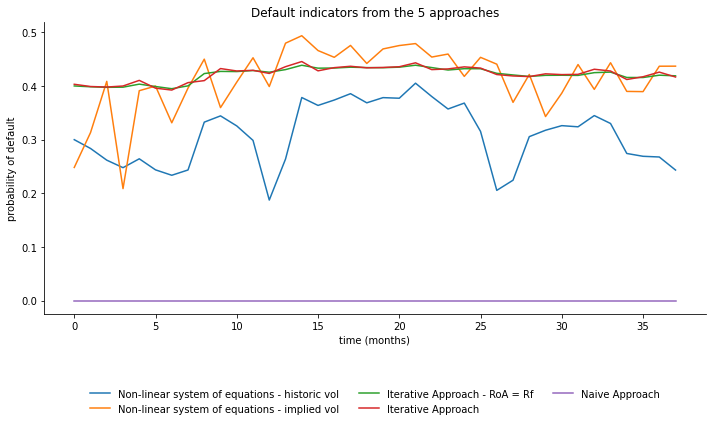

In [29]:
fig = plt.figure(figsize=(10,5), alpha = 0.5)

#Non-linear system of equations
plt.plot(parameters['PD'], label = 'Non-linear system of equations - historic vol')

#Non-linear system of equations
plt.plot(parameters_c['PD'], label = 'Non-linear system of equations - implied vol')

#Iterative Approach
plt.plot(df_iter['PD'], label = 'Iterative Approach - RoA = Rf')

#Iterative Approach
plt.plot(df_iter2['PD'], label = 'Iterative Approach')

#Naive Approach
plt.plot(df_naive['PD'], label = 'Naive Approach')

#Eliminating Spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#Setting title
plt.title('Default indicators from the 5 approaches')

#Labeling axis
plt.xlabel('time (months)')
plt.ylabel('probability of default')


plt.tight_layout()
plt.legend(frameon=False, loc='center', ncol=3, bbox_to_anchor=(0.5, -0.3))